In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import cuml
import cupy as cp

from cuml.manifold import TSNE
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<AxesSubplot:>

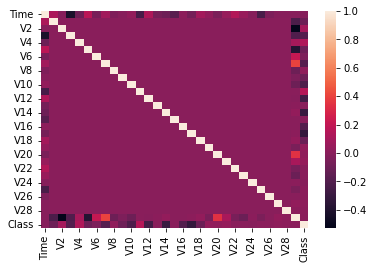

In [4]:
sns.heatmap(df.corr())

<AxesSubplot:xlabel='Time', ylabel='Count'>

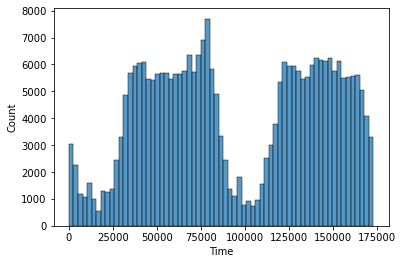

In [5]:
sns.histplot(df['Time'])

In [6]:
data_features = df.iloc[:, 1:-1]
scaler = RobustScaler()
scaled_data = pd.DataFrame(
    data=scaler.fit_transform(data_features), 
    columns=data_features.columns
)


# Outlier std

In [7]:
def outlier_std(data, col, threshold=3):
    mean = data[col].mean()
    std = data[col].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(1)
    return anomalies, up_bound, low_bound

In [8]:
def get_column_outliers(data, columns=None, function=outlier_std, threshold=3, n_anom=1):
    if columns:
        columns_to_check = columns
    else:
        columns_to_check = data.columns
        
    outliers = pd.Series(data=[0]*len(data), index=data_features.index, name='is_outlier')
    comparison_table = {}
    
    for column in columns_to_check:
        anomalies, upper_bound, lower_bound = function(data, column, threshold=threshold)
        comparison_table[column] = [upper_bound, lower_bound, sum(anomalies), 100*sum(anomalies)/len(anomalies)]
        outliers[anomalies[anomalies].index] += 1
    
    outliers = outliers >= n_anom # сделка аномальна, если она аномальна по n_anom признакам
    
    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns=['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_percentage']
    comparison_table = comparison_table.sort_values(by='anomalies_percentage', ascending=False)
    
    return comparison_table, outliers

def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:   {:.2f}%".format(
            sum(outliers), 100*sum(outliers)/len(outliers)))    

In [9]:
data_features = df.iloc[:, :-1]
data_features.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [10]:
comparison_table, std_outliers = get_column_outliers(data_features, threshold=10)
anomalies_report(std_outliers)

Total number of outliers: 2104
Percentage of outliers:   0.74%


In [11]:
df['Time']

0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64

## Перебор кол-ва сигм и кол-ва аномальных столбцов

In [87]:
for n_anom in range(1, 31):
    f1_list = np.array([])
    for i in range(3, 23):
        comparison_table, std_outliers = get_column_outliers(data_features, threshold=i, n_anom=n_anom)
        new_df = df.join(std_outliers.astype(int))
        
        tp = len(new_df[(new_df['Class'] == 1)&(new_df['is_outlier'] == 1)])
        fn = len(new_df[(new_df['Class'] == 0)&(new_df['is_outlier'] == 1)])
        
        tn = len(new_df[(new_df['Class'] == 0)&(new_df['is_outlier'] == 0)])
        fp = len(new_df[(new_df['Class'] == 1)&(new_df['is_outlier'] == 0)])
        
        try:
            precision = tp/(tp+fp)
            recall = tp/(tp+fn)
            f1 = 2 * ((precision*recall)/(precision+recall))
            f1_list  = np.append(f1_list, f1)
            
        except ZeroDivisionError:
            continue
            
    print(f'n_anom={n_anom}')
    print('Max f1:')
    print(np.max(f1_list))
    print(f'n_sigmas={np.argmax(f1_list)+3}')
    print("=="*20)

n_anom=1
Max f1:
0.19663299663299663
n_sigmas=14


KeyboardInterrupt: 

Возьмём за лучший результат при n_anom=12 и отколение в пределах n_sigmas>3

In [104]:
def estimate_anom_alg(tsne_transformed, outliers):
    tsne_transformed['predicted'] = outliers.astype('int')
    tsne_transformed['true'] = df['Class']
    tsne_transformed['perfomance'] = tsne_transformed['true'].astype(str) + \
                                                            tsne_transformed['predicted'].astype(str)
    
    tsne_transformed = tsne_transformed.replace(["00", "01", "11", "10"], ["TN", "FP", "TP", "FN"])
    
    groups = tsne_transformed.groupby('perfomance')
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Confusion plots', fontsize=20)


    for name, group in groups:
        if(name == "TN"):
            continue
        ax1.plot(group[0], group[1], marker='o', linestyle='', markersize=10, label=name)
    ax1.legend()

    groups = tsne_transformed.groupby('true')
    for name, group in groups:
        if(name == 0):
            continue
        ax2.plot(group[0], group[1], marker='o', linestyle='', markersize=10, label=name, color='green') 

    ax2.legend()

    fig.set_figheight(10)
    fig.set_figwidth(20)
    print(tsne_transformed.groupby(['perfomance']).size().reset_index(name='counts'))

## Проведём оценку неточностей

/home/yaroslav/.conda/envs/rapids-22.06/lib/python3.9/site-packages/cuml/internals/api_decorators.py:794: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [22:06:00.165050] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
  perfomance  counts
0         FN     340
1         FP     309
2         TN  284006
3         TP     152


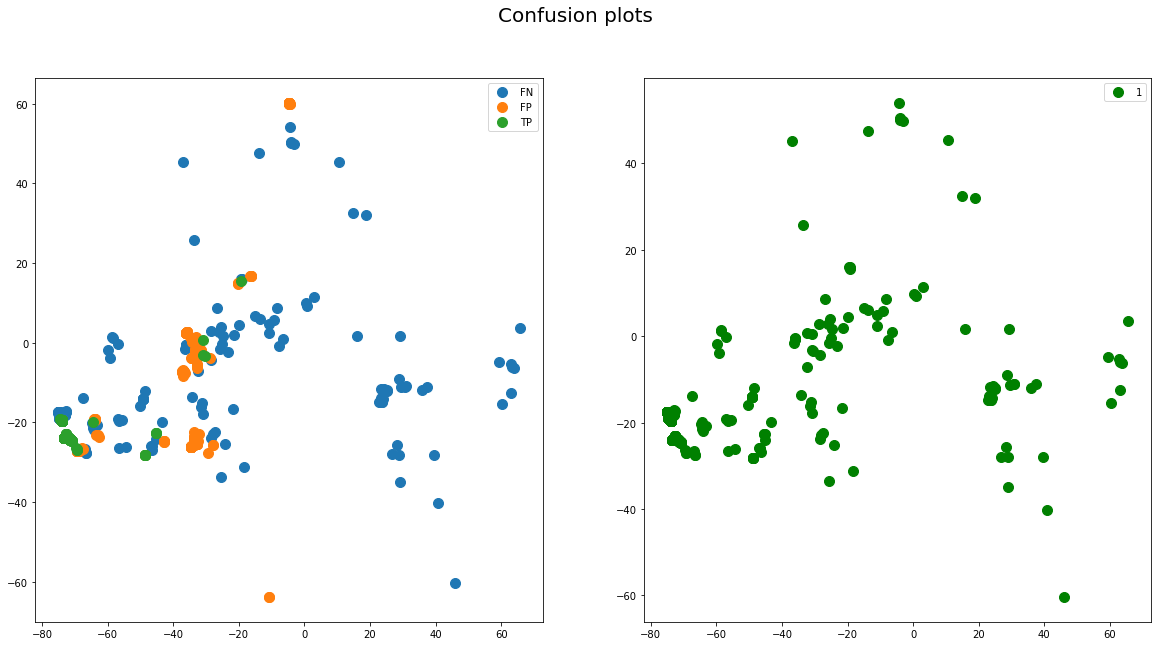

In [107]:
tsne = TSNE(n_components = 2, random_state=42)
tsne_transformed = tsne.fit_transform(scaled_data)
tsne_transformed = pd.DataFrame(tsne_transformed)

comparison_table, std_outliers = get_column_outliers(data_features, threshold=3, n_anom=12)
estimate_anom_alg(tsne_transformed, std_outliers)

# Distance Outliers

In [62]:
class DistanceOutliers(BaseEstimator):
    def __init__(self, metric='euclidean', percentile=90):
        self.metric = metric
        self.percentile = percentile
        
    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distances_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.threshold = np.percentile(distances_train, self.percentile)
        
    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.threshold).astype(int)
        return predictions

In [93]:
euclidian_model = DistanceOutliers(metric='euclidean', percentile=99)
euclidian_model.fit(df)
euclidian_outliers = euclidian_model.predict(df)
anomalies_report(euclidian_outliers)

Total number of outliers: 2849
Percentage of outliers:   1.00%


In [94]:
print(classification_report(df['Class'],euclidian_outliers.astype(int)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    284315
           1       0.00      0.00      0.00       492

    accuracy                           0.99    284807
   macro avg       0.50      0.50      0.50    284807
weighted avg       1.00      0.99      0.99    284807



  perfomance  counts
0         FN     490
1         FP    2847
2         TN  281468
3         TP       2


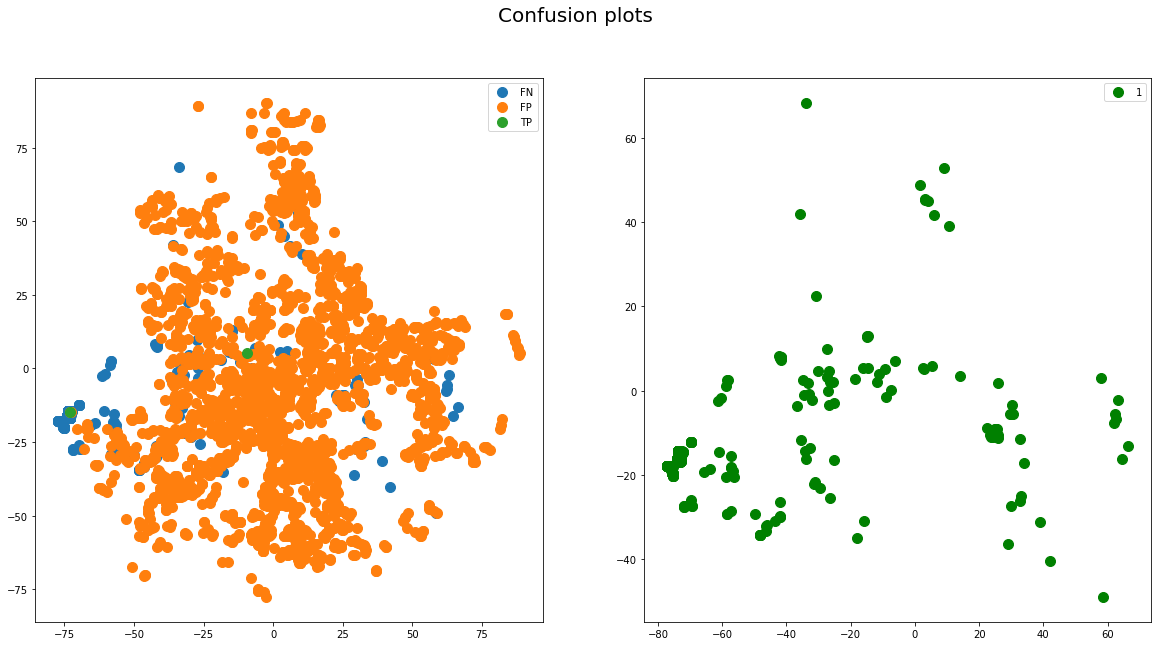

In [106]:
estimate_anom_alg(tsne_transformed, euclidian_outliers)

Эта модель нас не устраивает, так как очень много FP 

# CUDA Supported DBSCAN

In [ ]:
%%time

outlier_percentage = 0.05

num_clusters = []
anomaly_percentage = []

eps = 5
eps_history = [eps]

while outlier_percentage > 0.002:    
    model = cuml.DBSCAN(eps=eps, max_mbytes_per_batch=5120).fit(scaled_data)
    labels = model.labels_
    num_clusters.append(len(np.unique(labels))-1)
    labels = np.array([1 if label == -1 else 0 for label in labels])

    # запишем предыдущий prev_outlier_perc, для обновления pbar
    prev_outlier_perc = outlier_percentage 
    outlier_percentage = sum(labels==1) / len(labels)
    eps += 0.25
    eps_history.append(eps)
    anomaly_percentage.append(outlier_percentage)
    print(outlier_percentage)

In [99]:
model = cuml.DBSCAN(eps=6).fit(scaled_data)
labels = model.labels_
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

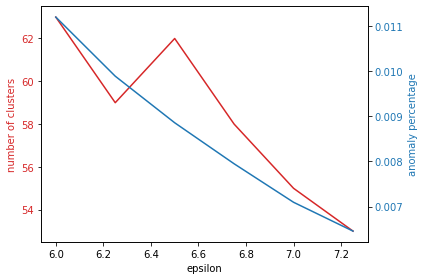

In [8]:
iterations = eps_history[:-1]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epsilon')
ax1.set_ylabel('number of clusters', color=color)
ax1.plot(iterations, num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('anomaly percentage', color=color)  
ax2.plot(iterations, anomaly_percentage, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

In [100]:
density_outlier = np.array([1 if label == -1 else 0 for label in model.labels_])

  perfomance  counts
0         FN     300
1         FP    2998
2         TN  281317
3         TP     192


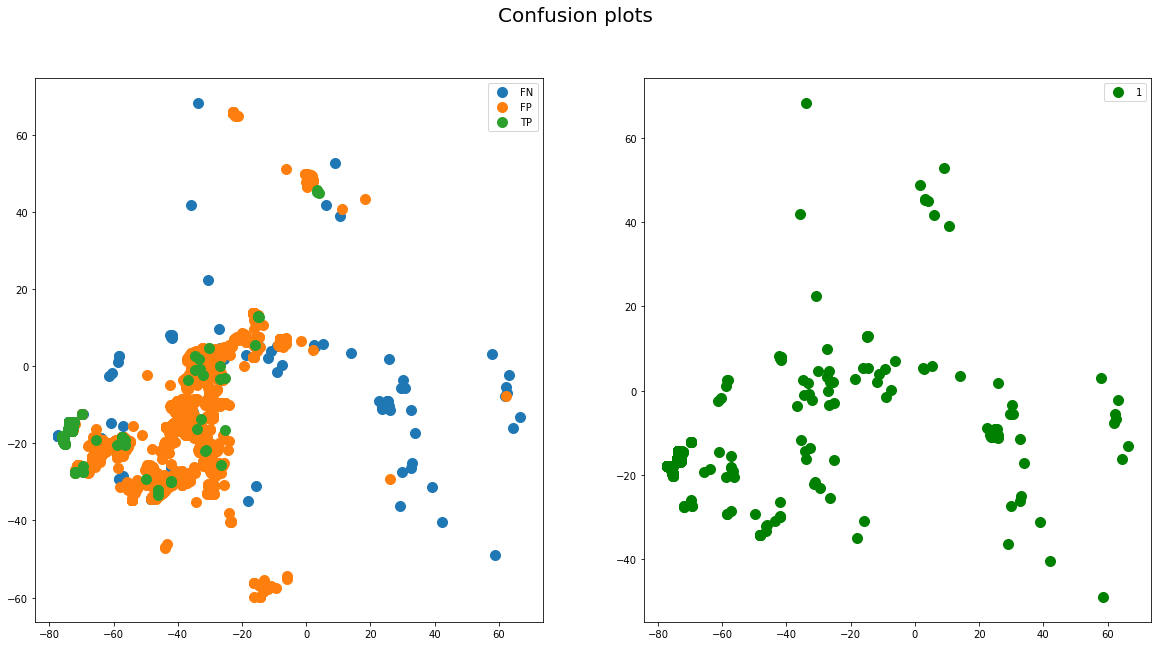

In [105]:
estimate_anom_alg(tsne_transformed, density_outlier)